### Loading Data

In [110]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline

# Load dataset
import kagglehub
path = kagglehub.dataset_download("uciml/autompg-dataset")
file_path = os.path.join(path, "auto-mpg.csv")
df = pd.read_csv(file_path)
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


### Data Wrangling

In [111]:
df.replace('?', np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)
df['horsepower'] = df['horsepower'].astype(float)
df.fillna(df.median(numeric_only=True), inplace=True)

# Convert target to l/100km
df['mpg'] = 235.21 / df['mpg']
df.rename(columns={"mpg": "l/100km"}, inplace=True)

### Some exercises with pandas

In [112]:
dummies = pd.get_dummies(df['car name'])
numeric_df = df.select_dtypes(include=[np.number])
list_with_nans = [col for col in numeric_df if df[col].isna().any()]
df[list_with_nans] = df[list_with_nans].fillna(df[list_with_nans].median())
print(numeric_df.corr())
print()
print(numeric_df.groupby(["cylinders"],as_index=False)[["l/100km"]].mean())
print()

Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = {}
for col in numeric_df.columns:
    mask = (df[col] < lower_bound[col]) | (df[col] > upper_bound[col])
    if mask.any():
        outliers[col] = df.loc[mask, col]
        
combined_mask = pd.DataFrame(outliers)
print(combined_mask)

               l/100km  cylinders  displacement  horsepower    weight  \
l/100km       1.000000   0.839278      0.866631    0.852935  0.885219   
cylinders     0.839278   1.000000      0.950721    0.841284  0.896017   
displacement  0.866631   0.950721      1.000000    0.895778  0.932824   
horsepower    0.852935   0.841284      0.895778    1.000000  0.862442   
weight        0.885219   0.896017      0.932824    0.862442  1.000000   
acceleration -0.455750  -0.505419     -0.543684   -0.686590 -0.417457   
model year   -0.557427  -0.348746     -0.370164   -0.413733 -0.306564   
origin       -0.530213  -0.562543     -0.609409   -0.452096 -0.581024   

              acceleration  model year    origin  
l/100km          -0.455750   -0.557427 -0.530213  
cylinders        -0.505419   -0.348746 -0.562543  
displacement     -0.543684   -0.370164 -0.609409  
horsepower       -0.686590   -0.413733 -0.452096  
weight           -0.417457   -0.306564 -0.581024  
acceleration      1.000000    0.2881

C:\Users\tobia\miniconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


      l/100km  cylinders  displacement  horsepower  weight  acceleration  \
300  9.841423          8         260.0        90.0    3420          22.2   
364  8.842481          8         350.0       105.0    3725          19.0   

     model year  origin                           car name  cluster  
300          79       1  oldsmobile cutlass salon brougham        1  
364          81       1              oldsmobile cutlass ls        1  
     l/100km  cylinders  displacement  horsepower  weight  acceleration  \
54  6.720286          4          72.0        69.0    1613          18.0   

    model year  origin     car name  cluster  
54          71       3  datsun 1200        0  


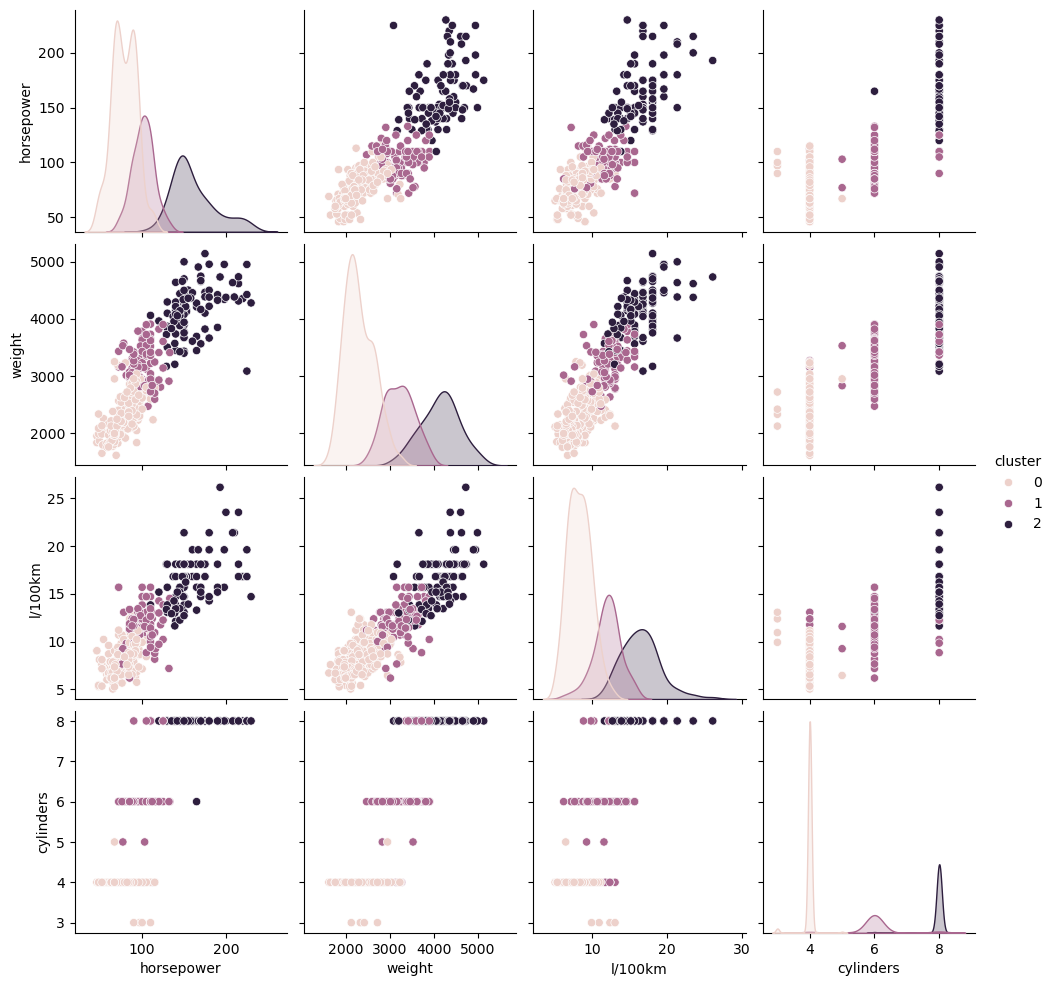

In [113]:
features = ['horsepower', 'weight', 'cylinders', 'l/100km']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(X_scaled)

sns.pairplot(df, vars=['horsepower', 'weight', 'l/100km', 'cylinders'], hue='cluster')
plt.savefig(r"C:\Users\tobia\jupyter_plots\cluster_hp_vs_l100km.png", dpi=300, bbox_inches='tight')

# > 6 cylinders and < 10 l/100km
interesting_cars = df[(df['cluster'] == 1) & (df['cylinders'] > 6) & (df['l/100km'] < 10)]
print(interesting_cars)

interesting_cars = df[df['weight'] == df['weight'].min()]
print(interesting_cars)

plt.show()

# Model Development

### Basic Linear Regression

C:\Users\tobia\AppData\Local\Temp\ipykernel_2920\515209488.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


R^2 (MLR): 0.8843299588660949
MSE (MLR): 1.7567263492611156


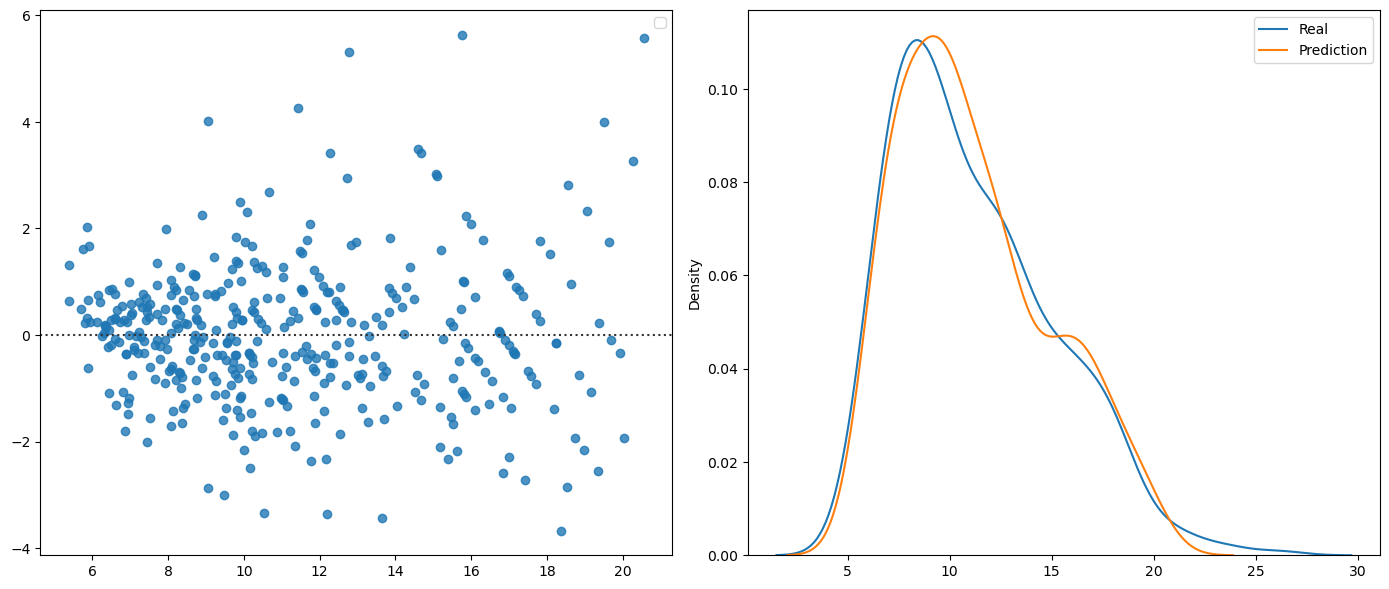

In [121]:
lm = LinearRegression()
Z = df[['horsepower','weight','cylinders', 'displacement', 'acceleration', 'model year']]
Y = df[['l/100km']]
lm.fit(Z, Y)
Y_hat = lm.predict(Z)

residuals = Y.values.flatten() - Y_hat.flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.residplot(x=Y_hat.flatten(), y=residuals)
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(Y.values.flatten(), label='Real')
sns.kdeplot(Y_hat.flatten(), label='Prediction')
plt.legend()

plt.tight_layout()
print("R^2 (MLR):", r2_score(Y, Y_hat))
print("MSE (MLR):", mean_squared_error(Y, Y_hat))
plt.show()

### Polynomial Regression without regularization

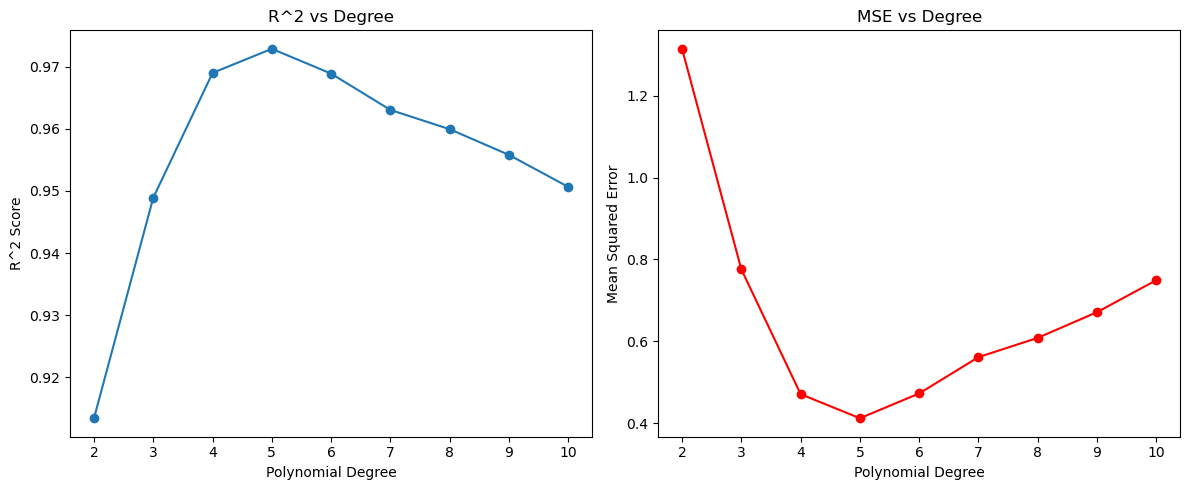

Degree 2: R^2: 0.9134, MSE: 1.3150


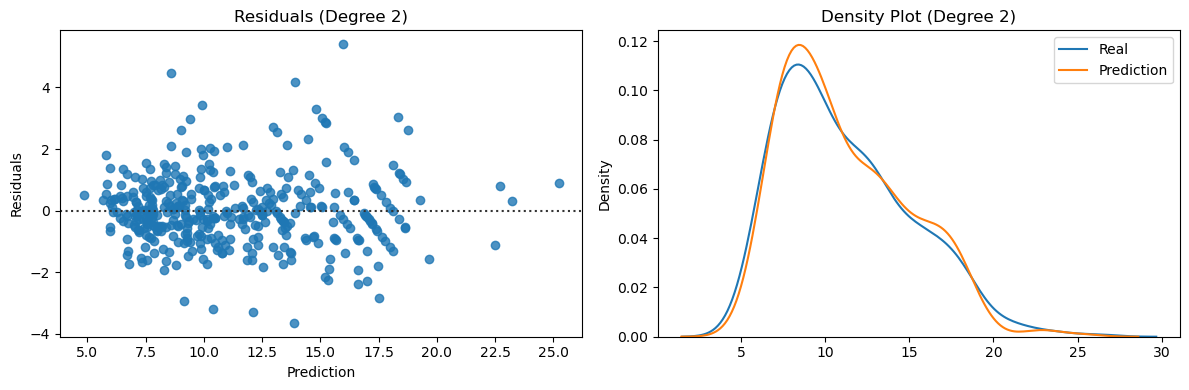

Degree 3: R^2: 0.9489, MSE: 0.7759


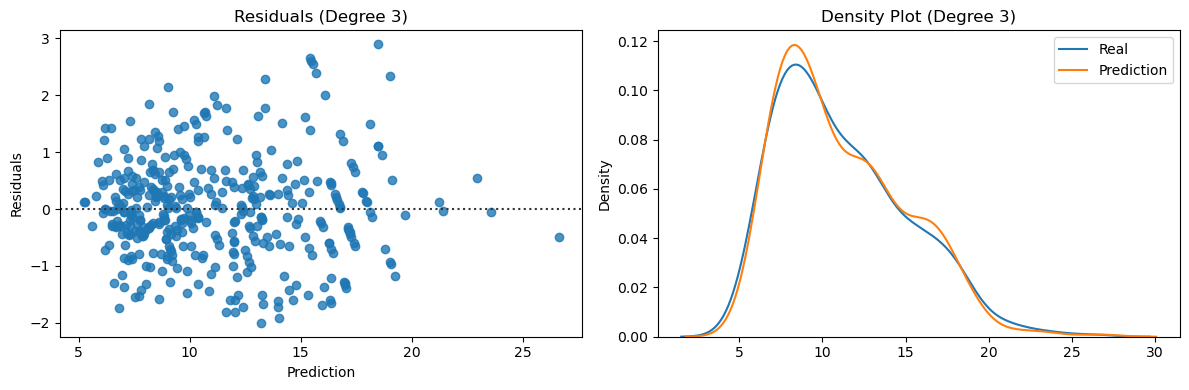

Degree 4: R^2: 0.9690, MSE: 0.4709


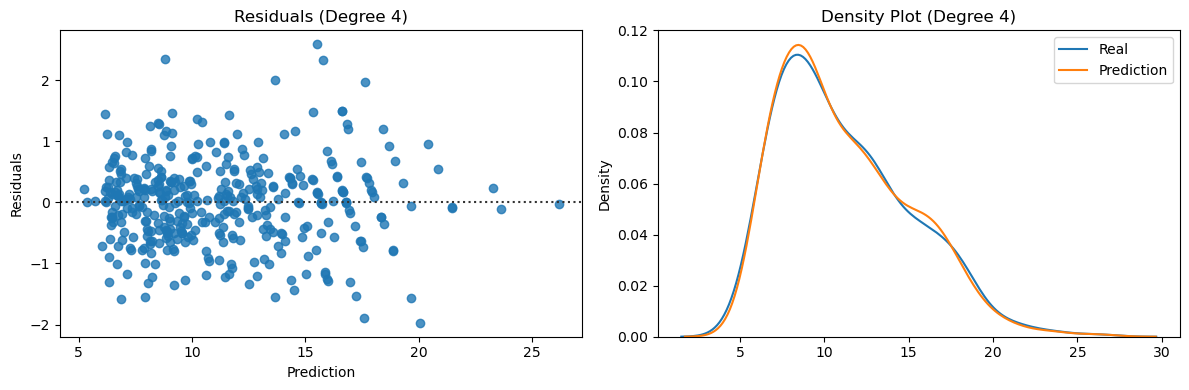

Degree 5: R^2: 0.9729, MSE: 0.4119


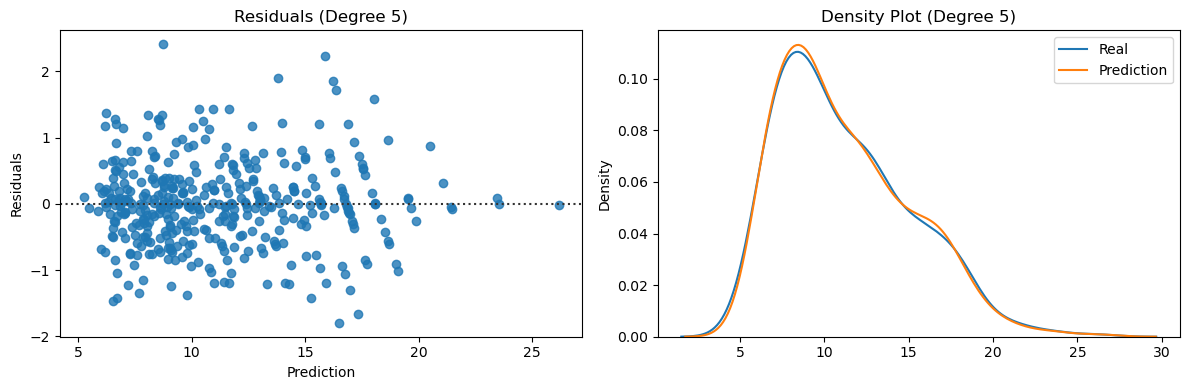

Degree 6: R^2: 0.9689, MSE: 0.4726


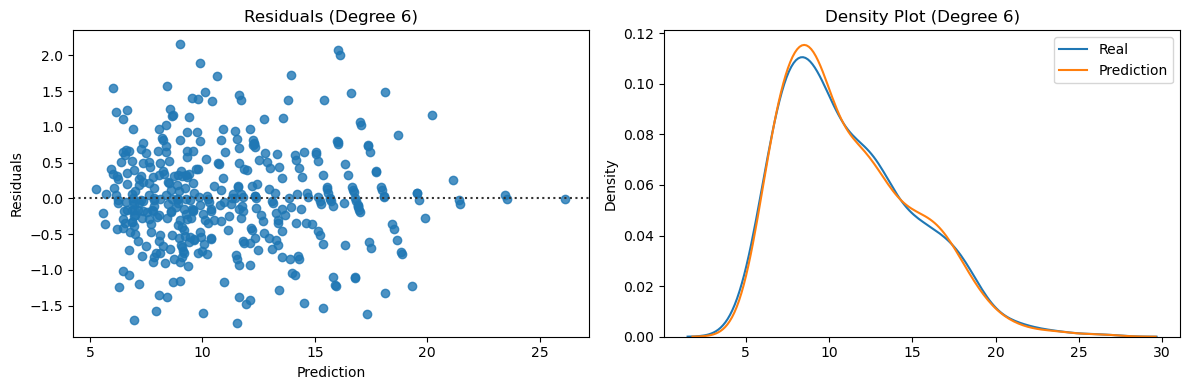

Degree 7: R^2: 0.9630, MSE: 0.5613


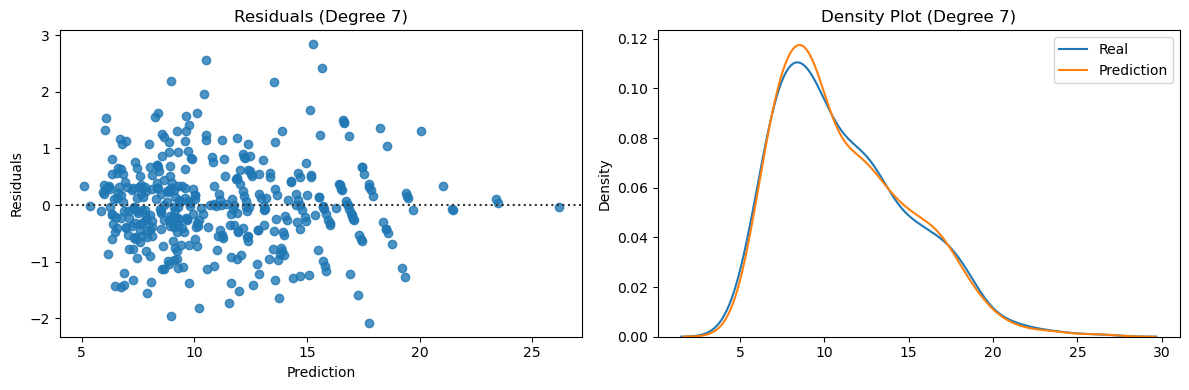

Degree 8: R^2: 0.9599, MSE: 0.6084


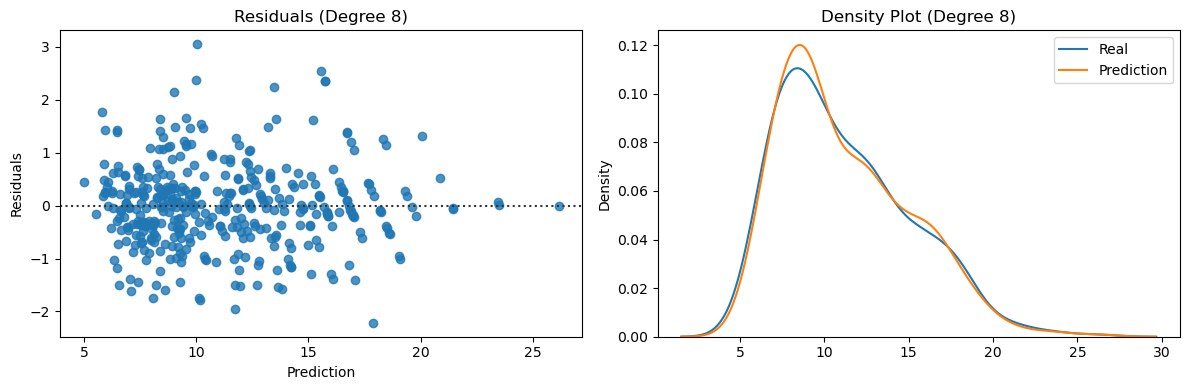

Degree 9: R^2: 0.9558, MSE: 0.6712


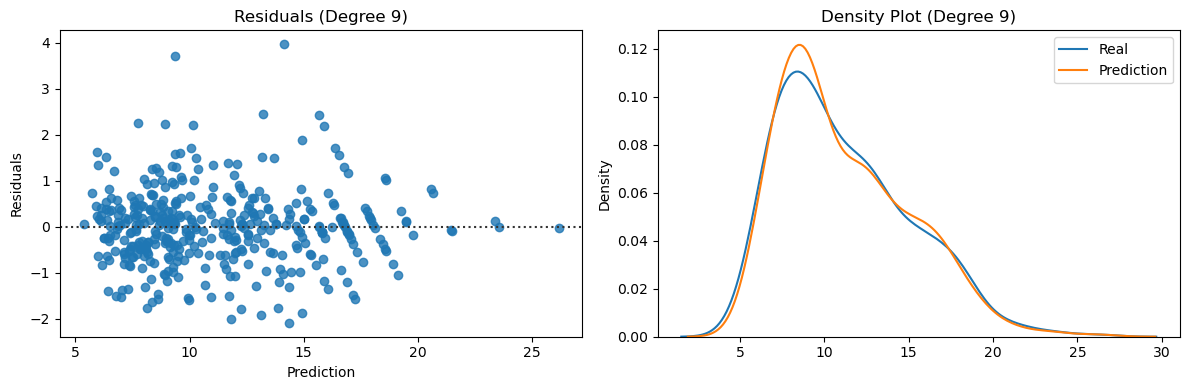

Degree 10: R^2: 0.9507, MSE: 0.7494


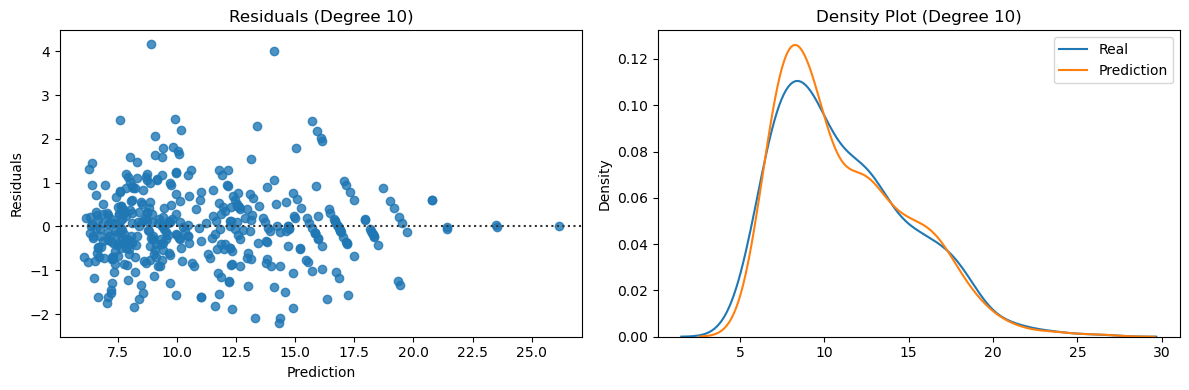

Best combination at degree 5 -> R^2 = 0.9728784996036919, MSE = 0.41190487969597966


In [127]:
# Evaluate polynomial models of increasing degree
r2_scores = []
mse_scores = []
degrees = range(2, 11)
Y_poly_hats = []

for degree in degrees:
    # Generate polynomial features
    pr = PolynomialFeatures(degree=degree)
    Z_poly = pr.fit_transform(Z)

    # Fit linear regression to polynomial features
    lm_poly = LinearRegression()
    lm_poly.fit(Z_poly, Y)
    Y_poly_hat = lm_poly.predict(Z_poly)
    Y_poly_hats.append(Y_poly_hat)

    # Calculate R^2 and MSE
    r2 = r2_score(Y, Y_poly_hat)
    mse = mean_squared_error(Y, Y_poly_hat)
    r2_scores.append(r2)
    mse_scores.append(mse)

# Plot R^2 and MSE vs polynomial degree
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(degrees, r2_scores, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R^2 Score')
plt.title('R^2 vs Degree')

plt.subplot(1, 2, 2)
plt.plot(degrees, mse_scores, marker='o', color='red')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Degree')
plt.tight_layout()
plt.show()

# Plot residuals and KDE for each degree
for i, hat in enumerate(Y_poly_hats):
    residuals_poly = Y.values.flatten() - hat.flatten()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    r2_val = r2_scores[i]
    mse_val = mse_scores[i]
    print(f"Degree {degrees[i]}: R^2: {r2_val:.4f}, MSE: {mse_val:.4f}")

    # Residual plot
    sns.residplot(x=hat.flatten(), y=residuals_poly, ax=axes[0])
    axes[0].set_title(f'Residuals (Degree {degrees[i]})')
    axes[0].set_xlabel('Prediction')
    axes[0].set_ylabel('Residuals')

    # KDE comparison
    sns.kdeplot(Y.values.flatten(), label='Real', ax=axes[1])
    sns.kdeplot(hat.flatten(), label='Prediction', ax=axes[1])
    axes[1].set_title(f'Density Plot (Degree {degrees[i]})')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"jupyter_plots/kde_resid_degree_{degrees[i]}.png", dpi=300)
    plt.show()

# Combine scaled R^2 and MSE to find best degree
r2_arr = np.array(r2_scores).reshape(-1, 1)
r2_scaled = MinMaxScaler().fit_transform(r2_arr)

mse_arr = np.array(mse_scores).reshape(-1, 1)
mse_neg_scaled = MinMaxScaler().fit_transform(-mse_arr)

combined_score = r2_scaled.flatten() + mse_neg_scaled.flatten()
best_index = np.argmax(combined_score)

print(f"Best combination at degree {degrees[best_index]} "
      f"-> R^2 = {r2_scores[best_index]}, MSE = {mse_scores[best_index]}")

### Test for overfitting with cross-validation

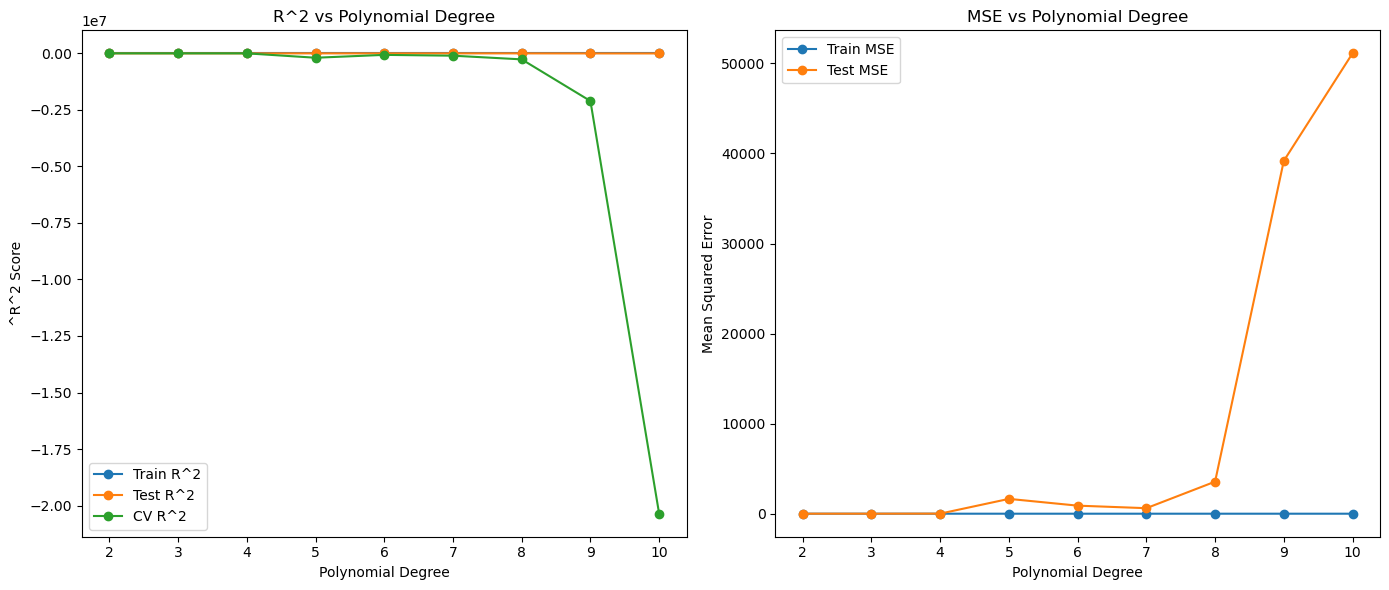

[LinearRegression + CV] Best combination at degree 2 -> CV R^2 = 0.5161995490850159, test MSE = 1.31876655702207


In [128]:
# Evaluate model generalization with train/test split and CV
degrees = range(2, 11)
train_r2 = []
test_r2 = []
train_mse = []
test_mse = []
cv_r2 = []
Z_train, Z_test, Y_train, Y_test = train_test_split(Z, Y, test_size=0.2, random_state=1)

# Create pipeline
for degree in degrees:
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('model', LinearRegression())
    ])
    
    pipe.fit(Z_train, Y_train)
    Y_train_hat = pipe.predict(Z_train)
    Y_test_hat = pipe.predict(Z_test)

    train_r2.append(r2_score(Y_train, Y_train_hat))
    test_r2.append(r2_score(Y_test, Y_test_hat))
    train_mse.append(mean_squared_error(Y_train, Y_train_hat))
    test_mse.append(mean_squared_error(Y_test, Y_test_hat))

    scores = cross_val_score(pipe, Z, Y, cv=5, scoring='r2')
    cv_r2.append(scores.mean())

# Plot R^2 and MSE for each degree
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(degrees, train_r2, label='Train R^2', marker='o')
plt.plot(degrees, test_r2, label='Test R^2', marker='o')
plt.plot(degrees, cv_r2, label='CV R^2', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('^R^2 Score')
plt.title('R^2 vs Polynomial Degree')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(degrees, train_mse, label='Train MSE', marker='o')
plt.plot(degrees, test_mse, label='Test MSE', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Polynomial Degree')
plt.legend()

plt.tight_layout()
plt.show()

# Combine CV R^2 and test MSE into a selection score
cv_r2_arr = np.array(cv_r2).reshape(-1, 1)
cv_r2_scaled = MinMaxScaler().fit_transform(cv_r2_arr)

test_mse_arr = np.array(test_mse).reshape(-1, 1)
test_mse_neg_scaled = MinMaxScaler().fit_transform(-test_mse_arr)

combined_score = cv_r2_scaled.flatten() + test_mse_neg_scaled.flatten()
best_index = np.argmax(combined_score)

print(f"[LinearRegression + CV] Best combination at degree {degrees[best_index]} "
      f"-> CV R^2 = {cv_r2[best_index]}, test MSE = {test_mse[best_index]}")

### Polynomial Ridge Regression with GridSearchCV

Degree 2: best alpha = 10, CV R^2 = 0.8884688381314328, Train MSE = 1.425434796013399


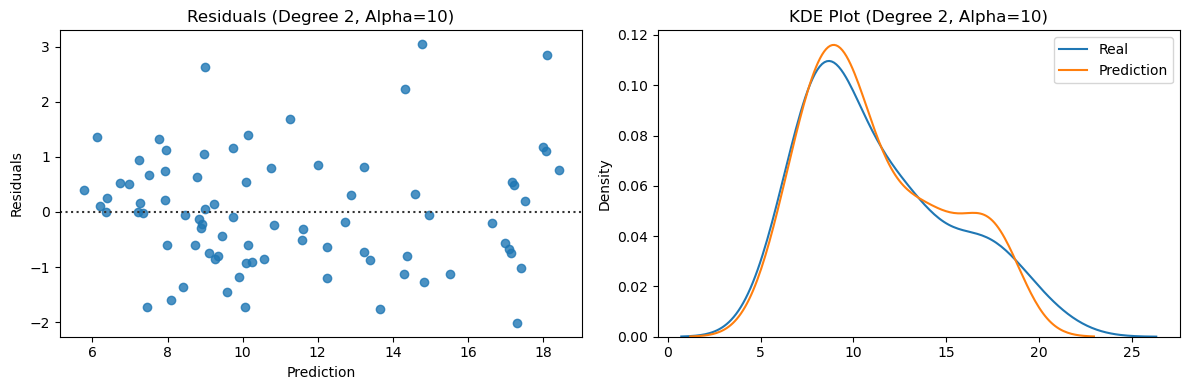

Degree 3: best alpha = 10, CV R^2 = 0.8829257758794705, Train MSE = 1.0254503305989404


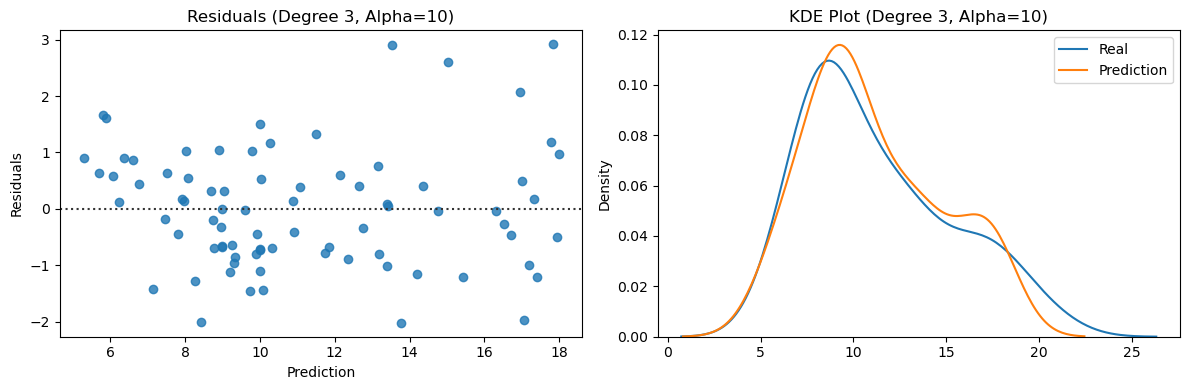

Degree 4: best alpha = 10, CV R^2 = 0.8279870162311533, Train MSE = 0.7790538593308981


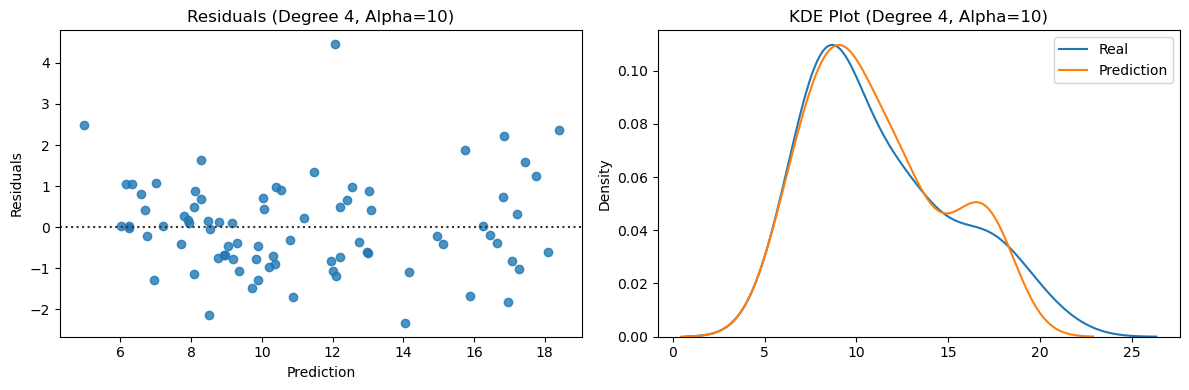

Degree 5: best alpha = 90, CV R^2 = 0.7686698058056731, Train MSE = 0.953186008853983


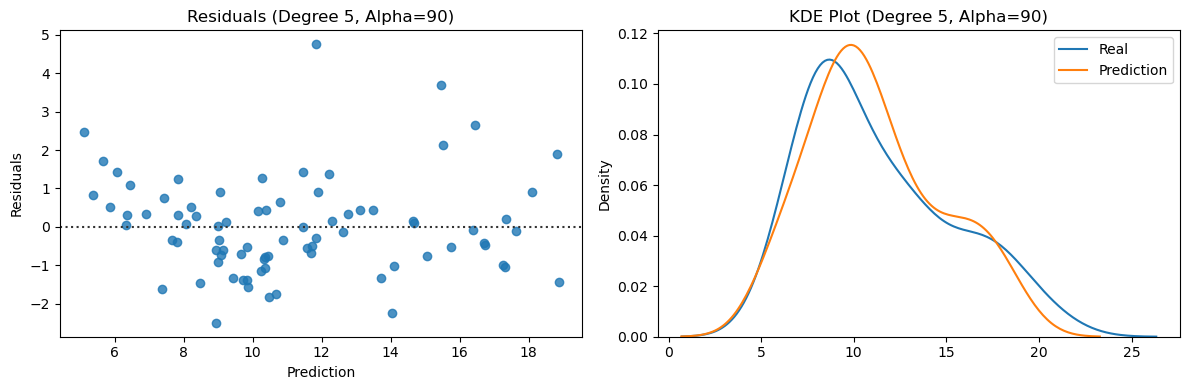

Degree 6: best alpha = 500, CV R^2 = 0.6024874016406931, Train MSE = 1.3313701436787742


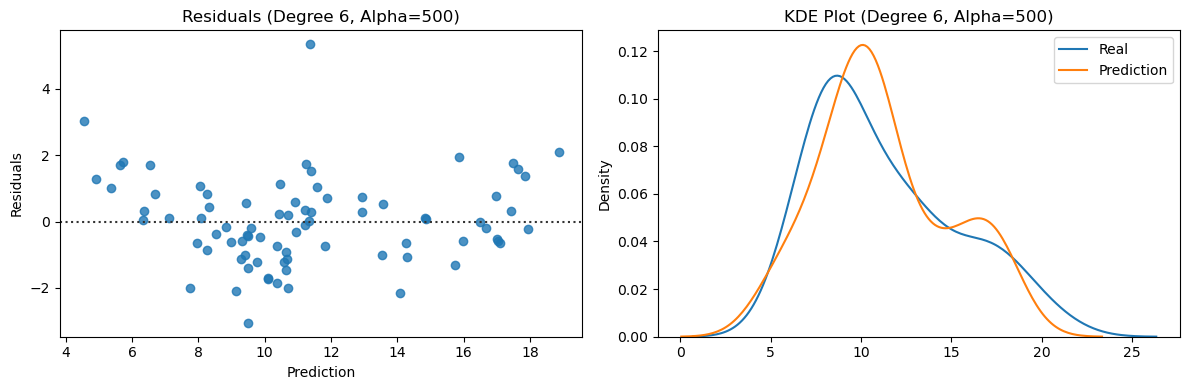

Degree 7: best alpha = 800, CV R^2 = 0.005297493313735346, Train MSE = 1.3051070727102598


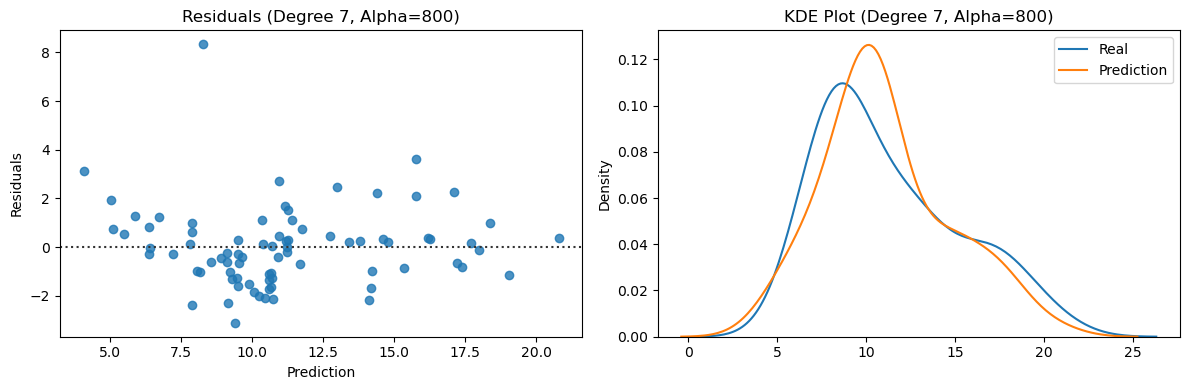

Degree 8: best alpha = 800, CV R^2 = -3.5197308360383763, Train MSE = 1.1376782183808412


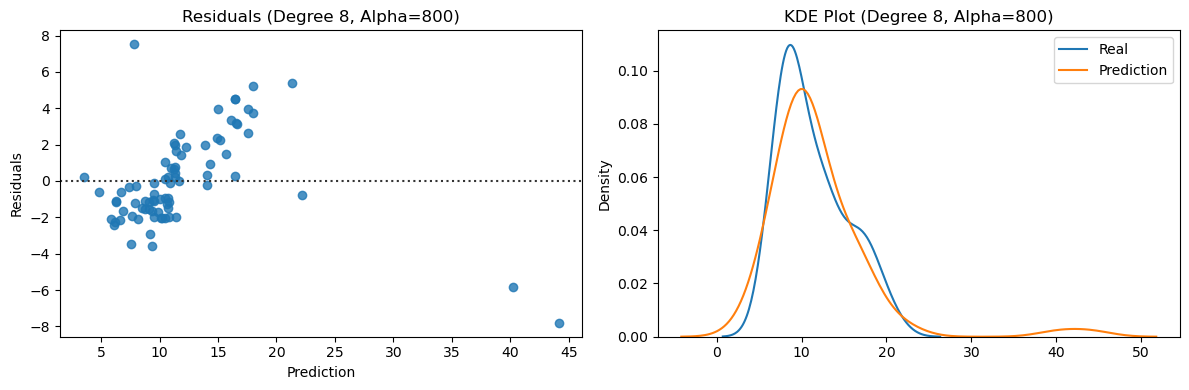

Degree 9: best alpha = 800, CV R^2 = -15.286476135797631, Train MSE = 0.9665893290431512


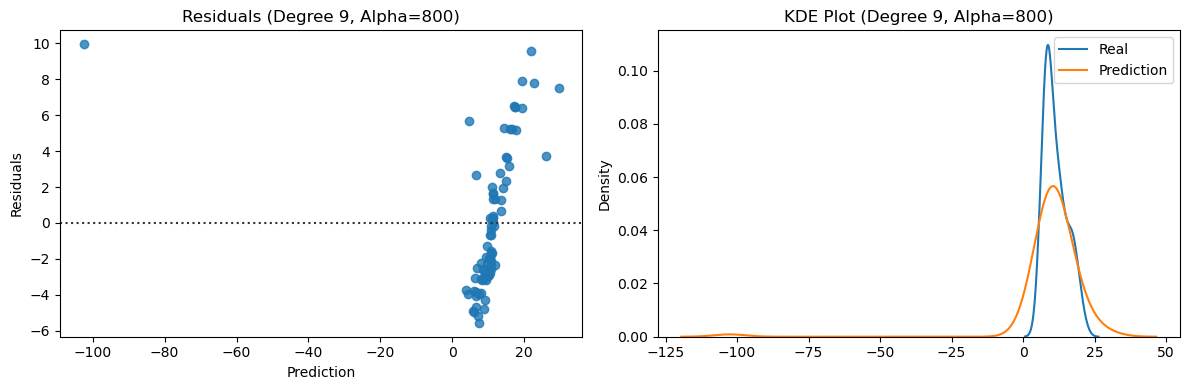

Degree 10: best alpha = 800, CV R^2 = -194.7003502514844, Train MSE = 0.8729009938364667


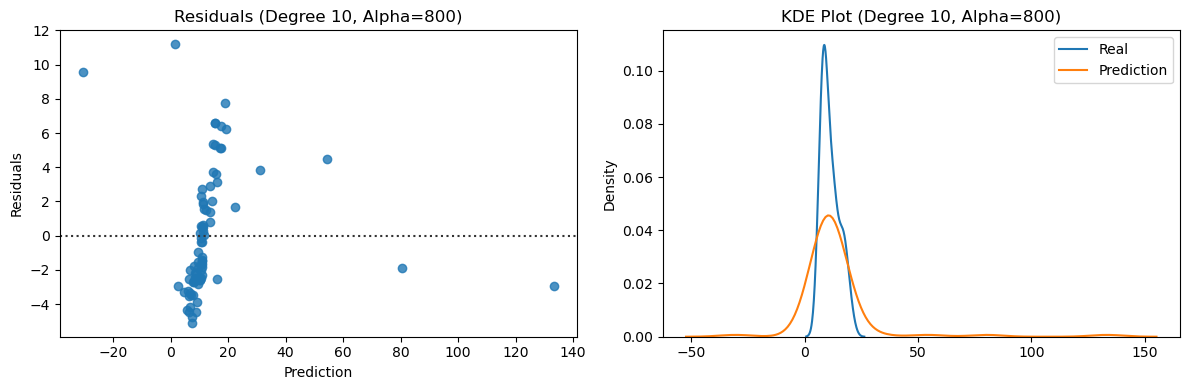

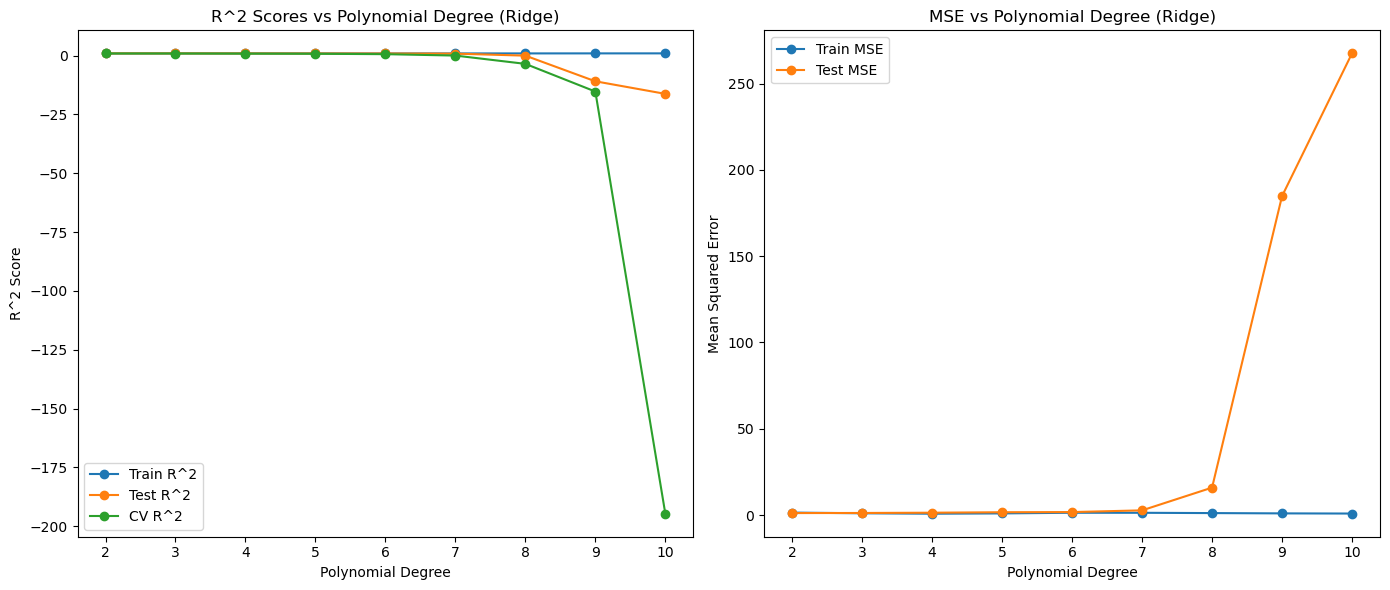

[Ridge + GridSearchCV] Best combination at degree 2 -> CV R^2 = 0.8884688381314328, test MSE = 1.1415681657259853, alpha = 10


In [129]:
Z_train, Z_test, Y_train, Y_test = train_test_split(Z, Y, test_size=0.2, random_state=1)
# Alpha values to test
alpha_grid = [0.001, 0.01, 0.1, 1, 10, 90, 100, 110, 200, 300, 400, 500, 600, 700, 800]
degrees = range(2, 11)

# Result lists
train_r2, test_r2, train_mse, test_mse, best_alphas, cv_r2 = [], [], [], [], [], []

# Create pipeline for each degree
for degree in degrees:
    pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('model', Ridge())
    ])

    # GridSearch to find the best alpha
    param_grid = {'model__alpha': alpha_grid}
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
    grid.fit(Z_train, Y_train)

    best_model = grid.best_estimator_
    best_alpha = grid.best_params_['model__alpha']
    best_alphas.append(best_alpha)
    cv_r2.append(grid.best_score_)

    # Predict on train and test sets
    Y_train_hat = best_model.predict(Z_train)
    Y_test_hat = best_model.predict(Z_test)

    # Evaluate r^2 and MSE
    train_r2.append(r2_score(Y_train, Y_train_hat))
    test_r2.append(r2_score(Y_test, Y_test_hat))
    train_mse_val = mean_squared_error(Y_train, Y_train_hat)
    test_mse_val = mean_squared_error(Y_test, Y_test_hat)
    train_mse.append(train_mse_val)
    test_mse.append(test_mse_val)
    print(f"Degree {degree}: best alpha = {best_alpha}, CV R^2 = {grid.best_score_}, Train MSE = {train_mse_val}")
    mean_squared_error(Y_train, Y_train_hat)

    # Plot residuals and KDE for each degree
    residuals = Y_test.values.flatten() - Y_test_hat.flatten()
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Residual plot
    sns.residplot(x=Y_test_hat.flatten(), y=residuals, ax=axes[0])
    axes[0].set_title(f"Residuals (Degree {degree}, Alpha={best_alpha})")
    axes[0].set_xlabel("Prediction")
    axes[0].set_ylabel("Residuals")

    # KDE plot
    sns.kdeplot(Y_test.values.flatten(), label='Real', ax=axes[1])
    sns.kdeplot(Y_test_hat.flatten(), label='Prediction', ax=axes[1])
    axes[1].set_title(f"KDE Plot (Degree {degree}, Alpha={best_alpha})")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# R^2 comparison
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(degrees, train_r2, label='Train R^2', marker='o')
plt.plot(degrees, test_r2, label='Test R^2', marker='o')
plt.plot(degrees, cv_r2, label='CV R^2', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R^2 Score')
plt.title('R^2 Scores vs Polynomial Degree (Ridge)')
plt.legend()

# MSE comparison
plt.subplot(1, 2, 2)
plt.plot(degrees, train_mse, label='Train MSE', marker='o')
plt.plot(degrees, test_mse, label='Test MSE', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Polynomial Degree (Ridge)')
plt.legend()
plt.tight_layout()
plt.show()

# Finding the best Ridge model
cv_r2_arr = np.array(cv_r2).reshape(-1, 1)
cv_r2_scaled = MinMaxScaler().fit_transform(cv_r2_arr)

test_mse_arr = np.array(test_mse).reshape(-1, 1)
test_mse_neg_scaled = MinMaxScaler().fit_transform(-test_mse_arr)

combined_score = cv_r2_scaled.flatten() + test_mse_neg_scaled.flatten()
best_index = np.argmax(combined_score)

print(f"[Ridge + GridSearchCV] Best combination at degree {degrees[best_index]} "
      f"-> CV R^2 = {cv_r2[best_index]}, test MSE = {test_mse[best_index]}, alpha = {best_alphas[best_index]}")